#### Examples
1. https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm  
2. https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1/

## PROJECT SUMMARY
Predicting future oil production rates for 5 oil wells

Using the contents of the entire workbook create a 2 paragraph project introduction for ... project. The first paragraph should describe what the project is about and the base LSTM model being used. The second paragraph gives a brief summary of the steps that will be taken to analyze, train, and evaluate the model including EDA, training, testing, hyperparameter tuning, and comparing the base model to the .......... models.

## DATA SOURCE & IMPORT

#### Data Source

- The datasets used in this project are a combination of production data for five crude oil wells and commodity pricing data.
- **Production Data**
  - The historical production data has been provided directly by a small Canadian oil and gas producer.  
  - *Reference*: Private Operator (Anonymous). (2025). Internal oil well production dataset: Five wells in Western Canada.
- **Commodity Pricing Data**
  - Historical crude oil and natural gas commodity pricing data is downloaded from a trusted Canadian petroleum reserve evaluator.
  - *Reference*: McDaniel & Associates Consultants Ltd. (2025, October 1). Price forecasts [Web page]. https://mcdan.com/price-forecasts/

#### Import Python Libraries

In [1]:
# Import core analysis, visualization, and statistical libraries used throughout the notebook
import random
import itertools
import warnings
import pandas as pd
import numpy as np
import json
from io import StringIO
from textwrap import fill
import requests
from fake_useragent import UserAgent
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Silence noisy warnings from third-party packages
warnings.filterwarnings('ignore', category=UserWarning)

# Allow Altair to render large datasets without automatic sampling
alt.data_transformers.disable_max_rows()

# Set seeds for consistent results
seed = 666
keras.utils.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define model constants
SCALING_FACTOR = 1e-6
SPLIT_RATIO = 0.8

2025-11-25 21:53:34.322609: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 21:53:34.363167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 21:53:35.294627: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 21:53:35.294627: I tensorflow/core/util/port.cc:153] oneDNN custom operations ar

#### Import Production Data
- Production data has been provided directly from the oil company in a `.csv` file.

In [2]:
# Import production dataset file (as provided by the private oil company)
prod_df = pd.read_csv('prod.csv')

# Convert date column to datetime
prod_df['date'] = pd.to_datetime(prod_df['date'])

# Display production dataframe
prod_df

,well_name,date,production_hours,oil_volume (bbl),gas_volume (mcf),water_volume (bbl),oil_producing_daily_avg (bbl/day),gas_producing_daily_avg (mcf/day),water_producing_daily_avg (bbl/day)
0,well_1,2013-01-01,408,279708.0,86167.0,24467.0,16453.411765,5068.647059,1439.235294
1,well_1,2013-02-01,629,423556.0,133842.0,10189.0,16161.119237,5106.848967,388.769475
2,well_1,2013-03-01,743,491737.0,300173.0,10378.0,15883.833109,9696.032301,335.224764
3,well_1,2013-04-01,720,377074.0,326659.0,3585.0,12569.133333,10888.633333,119.500000
4,well_1,2013-05-01,696,301911.0,220009.0,4906.0,10410.724138,7586.517241,169.172414
...,...,...,...,...,...,...,...,...,...
477,well_5,2018-08-01,120,503.0,353.0,126.0,100.600000,70.600000,25.200000
478,well_5,2018-09-01,720,1635.0,5650.0,7925.0,54.500000,188.333333,264.166667
479,well_5,2019-03-01,27,0.0,1059.0,0.0,0.000000,941.333333,0.000000
480,well_5,2019-04-01,24,0.0,1413.0,0.0,0.000000,1413.000000,0.000000


#### Import Commodity Pricing Data
- Commodity price data in `json` format is extracted directly from the McDaniel's website.

In [3]:
# Function to load the commodity price json file and convert it into a dataframe
def import_price_data(url):
    response = requests.get(url, headers={'User-Agent': UserAgent().random})

    data = json.loads(response.content)

    rows = []
    for entry in data:
        date = entry['date']
        row = {'date': date}
        for item in entry['values']:
            base_key = item['key'].replace(' Forecast', '').strip()
            row[f'{base_key}'] = item['usd']
        rows.append(row)
    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(df['date'])
    return df

# Define the url links to the pricing data
oil_url = 'https://mcdan.com/forecast/data/oil.json'
gas_url = 'https://mcdan.com/forecast/data/gas.json'

# Create oil and natural gas pricing datasets
oil_prices_df = import_price_data(oil_url)
gas_prices_df = import_price_data(gas_url)

#### Merge Production & Pricing Datasets
- Create the final dataset used for evaluation

In [4]:
# Merge the prod_df, oil_prices_df, and gas_prices_df
df = prod_df.merge(oil_prices_df).merge(gas_prices_df)

# Display combined dataset
df

,well_name,date,production_hours,oil_volume (bbl),gas_volume (mcf),water_volume (bbl),oil_producing_daily_avg (bbl/day),gas_producing_daily_avg (mcf/day),water_producing_daily_avg (bbl/day),WTI,BRENT,EDM,WCS,HH,AECO,STA2
0,well_1,2013-01-01,408,279708.0,86167.0,24467.0,16453.411765,5068.647059,1439.235294,94.83,112.16,88.10,62.09,3.33,3.18,3.08
1,well_1,2013-02-01,629,423556.0,133842.0,10189.0,16161.119237,5106.848967,388.769475,95.32,116.02,87.12,58.36,3.33,3.03,2.84
2,well_1,2013-03-01,743,491737.0,300173.0,10378.0,15883.833109,9696.032301,335.224764,92.96,108.56,86.95,66.71,3.81,2.96,2.79
3,well_1,2013-04-01,720,377074.0,326659.0,3585.0,12569.133333,10888.633333,119.500000,92.07,102.25,89.04,68.79,4.17,3.39,3.18
4,well_1,2013-05-01,696,301911.0,220009.0,4906.0,10410.724138,7586.517241,169.172414,94.80,102.56,93.55,81.07,4.04,3.63,3.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,well_5,2018-08-01,120,503.0,353.0,126.0,100.600000,70.600000,25.200000,68.06,72.53,64.93,48.91,2.91,1.58,1.08
478,well_5,2018-09-01,720,1635.0,5650.0,7925.0,54.500000,188.333333,264.166667,70.23,78.89,61.94,40.84,2.90,1.05,1.04
479,well_5,2019-03-01,27,0.0,1059.0,0.0,0.000000,941.333333,0.000000,58.15,66.14,54.49,48.06,2.95,1.55,0.99
480,well_5,2019-04-01,24,0.0,1413.0,0.0,0.000000,1413.000000,0.000000,63.86,71.23,59.16,53.26,2.65,1.16,0.65


## DATA SUMMARY

#### Dataset Shape & Data Types
- Investigating the number of rows and columns contained in the dataset, and the types of data found in each column.

In [5]:
# Dataset shape
(rows, cols) = df.shape
print(f'The dataset has {rows:,} rows and {cols} columns.\n')

# Dataset data types
df.info()

The dataset has 482 rows and 16 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   well_name                            482 non-null    object        
 1   date                                 482 non-null    datetime64[ns]
 2   production_hours                     482 non-null    int64         
 3   oil_volume (bbl)                     482 non-null    float64       
 4   gas_volume (mcf)                     482 non-null    float64       
 5   water_volume (bbl)                   482 non-null    float64       
 6   oil_producing_daily_avg (bbl/day)    482 non-null    float64       
 7   gas_producing_daily_avg (mcf/day)    482 non-null    float64       
 8   water_producing_daily_avg (bbl/day)  482 non-null    float64       
 9   WTI                                  482 non-

> The dataset consists mostly of numeric values but does contain one categorical column (`well_name`).

#### Feature Descriptions
- The dataset contains a combination of production volumes/rates and commodity pricing streams.

Feature | Description | Units
---|---|---
**well_name** | Name of the producing well |
**date** | First day of each month of production | dd/mm/yyy
**production_hours** | Number of producing hours a well is on production in a month | hours
**oil_volume (bbl)** | Volume of crude oil a well has produced in a month | bbl
**gas_volume (mcf)** | Volume of natural gas a well has produced in a month | mcf
**water_volume (bbl)** | Volume of water a well has produced in a month | bbl
**oil_producing_daily_avg (bbl/day)** | Monthly average of the daily oil production rate | bbl/d
**gas_producing_daily_avg (mcf/day)** | Monthly average of the daily natural gas production rate | mcf/d
**water_producing_daily_avg (bbl/day)** | Monthly average of the daily water production rate | bbl/d
**WTI** | Monthly average of the West Texas Intermediate crude oil benchmark price | US $/bbl
**BRENT** | Monthly average of the Brent crude oil benchmark price | US $/bbl
**EDM** | Monthly average of the Edmonton Light Sweet crude oil benchmark price | US $/bbl
**WCS** | Monthly average of the Western Canadian Select crude oil benchmark price | US $/bbl
**HH** | Monthly average of the Henry Hub natural gas benchmark price | US $/mcf
**AECO** | Monthly average of the AECO natural gas benchmark price | US $/mcf
**STA2** | Monthly average of the BC Station 2 natural gas benchmark price | US $/mcf


> The data for the oil, gas, and water production rates were pre-calculated by the oil company. To calculate these rates the following formula is used:

$$
\text{Monthly average of Daily Production Rates (bbl/d or mcf/d)} = \frac{\text{Monthly Volume Produced (bbl or mcf)}}{\text{Monthly Hours on Production (hours)}} \cdot 24 \text{(hours/day)}
$$

> For this project **the target variable is the `oil_producing_daily_avg (bbl/day)`** column. All of the other columns, excluding the `oil_volume (bbl)`, `gas_volume (mcf)`, and `water_volume (bbl)` columns, will be used as features during training. 

## EDA
The EDA section presents monthly production trends by well, blends in macro indicators, and highlights shut-in periods to reveal The EDA section traces monthly production trends for every well, overlaying macro pricing indicators and shut-in periods to surface operational cycles, sudden changes, and downtime. It also frames the upcoming train/test split within that historical context, so the LSTM preparation later clearly ties back to the exploratory insights.

#### Frequency of Categorical Columns
- Each well has produced for a different length of time, where each row in the dataset represents a month of production.
- It would be interesting to visualize how long each has produced for by counting the row occurrences in the `well_name` column.

In [6]:
# Visualize months on production
alt.Chart(df).mark_bar().encode(
    alt.X('well_name:N').title(None),
    alt.Y('count():Q').title(None),
    alt.Color('well_name').scale(scheme='viridis')
).properties(
    height = 300,
    width = 500,
    title=alt.Title('Months on Production by Well', fontSize=20, align='right'),
)

alt.Chart(...)

#### Distributions of Numeric Columns
- These are used to visualize how numeric columns are distributed, and to observe any patterns or outliers in the dataset.

In [7]:
# Function to plot a set of histograms for a subset of columns
def plot_numeric_histograms(input_df, subset, chart_title, col_count):
    # Melt the numeric columns into one column
    df_melt = input_df[subset].melt(var_name='feature', value_name='value')

    # Create a base Altair histogram chart
    base_chart = alt.Chart(df_melt).mark_bar(opacity=1, binSpacing=0).encode(
        alt.X('value:Q').axis(title=None).bin(maxbins=50),
        alt.Y('count():Q').axis(title=None).stack(None),
        color = alt.Color('feature:N').scale(scheme='viridis').sort(df.columns).legend(None)
    ).properties(
        width=750 / col_count,
        height=150
    )

    # Display a histogram for each numeric_columns
    chart = alt.ConcatChart(
        title=alt.Title(f'{chart_title}', fontSize=20),
        concat=[base_chart.transform_filter(alt.datum.feature == value).properties(title=value) for value in subset],
        columns=col_count,
    ).configure_title(
        fontSize=10
    ).resolve_axis(
        x='independent',
        y='independent'
    ).resolve_scale(
        x='independent', 
        y='independent'
    )

    return chart

numeric_columns = [col for col in df.columns.to_list() if col not in ['well_name','date']]

plot_numeric_histograms(df, numeric_columns, 'Numeric Columns Data Distributions', 3)

alt.ConcatChart(...)

> - The oil and water production data seem to be somewhat exponentially distributed, whereas the gas production has more variation and looks to be a skewed distribution.
> - The crude oil commodity prices (WTI, BRENT, EDM, WCS) all seem to have bi-modal distributions indicating that those prices experience high and low price environments.

#### Numeric Columns Pairplot
- This pairplot visualizes the scatterplots and histograms that reveals how production metrics and pricing indicators move together across wells

In [8]:
# # Isolate only numeric features for the PairGrid so comparisons are apples-to-apples
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# pairgrid_df = df[numeric_cols].dropna()

# # Configure the viridis-themed aesthetics shared across diagonal, upper, and lower plots
# sns.set_style('whitegrid')
# sns.set_context('talk', font_scale=0.9)
# sns.set_palette('viridis')
# viridis_colors = sns.color_palette('viridis_r', 5)
# hist_color = viridis_colors[2]
# scatter_color = viridis_colors[-1]
# kde_cmap = sns.color_palette('viridis', as_cmap=True)

# # Build the PairGrid with histograms on the diagonal, scatterplots above, and KDE contours below
# pairgrid = sns.PairGrid(pairgrid_df, diag_sharey=False)
# pairgrid.map_diag(sns.histplot, color=hist_color, edgecolor='white', linewidth=1.0)
# pairgrid.map_upper(sns.scatterplot, color=scatter_color, s=25, alpha=0.7, edgecolor='white', linewidth=0.3)
# pairgrid.map_lower(sns.kdeplot, fill=True, thresh=0.04, levels=5, cmap=kde_cmap, linewidths=0.8)

# # Rotate and wrap long axis labels so they stay legible in the grid
# for ax in pairgrid.axes.flatten():
#     ax.tick_params(axis='x', labelrotation=90)
#     ax.tick_params(axis='y', labelrotation=0)
#     ax.set_xlabel(fill(ax.get_xlabel(), 12))
#     ax.set_ylabel(fill(ax.get_ylabel(), 12))

# # Remove extra whitespace and add an overall title
# plt.subplots_adjust(wspace=0.05, hspace=0.05)
# pairgrid.fig.suptitle('Numeric Feature Relationships', y=1.02)

# pairgrid

> - Obvious correlations are observed between the production volumes and production rates. This makes sense since they are just a transformation of each other (as described in the Feature Descriptions section).
> - Correlations also exist among the crude oil pricing columns (`WTI`, `BRENT`, `EDM`, `WCS`). These are not unusual since most crude oils are priced relative to WTI. Similarly correlations are also observed for the natural gas prices between `AECO` and `STA2`. This is expected since both commodites are traded into similar markets.
> - No other obvious correlations are observed among the other numeric columns.

#### Correlation Matrix
- The correlation matrix is a heatmap of pairwise correlations between production and pricing features, helping this analysis quickly spot which variables move together before selecting inputs for the LSTM

<Axes: title={'center': 'Numeric Feature Correlation Matrix'}>

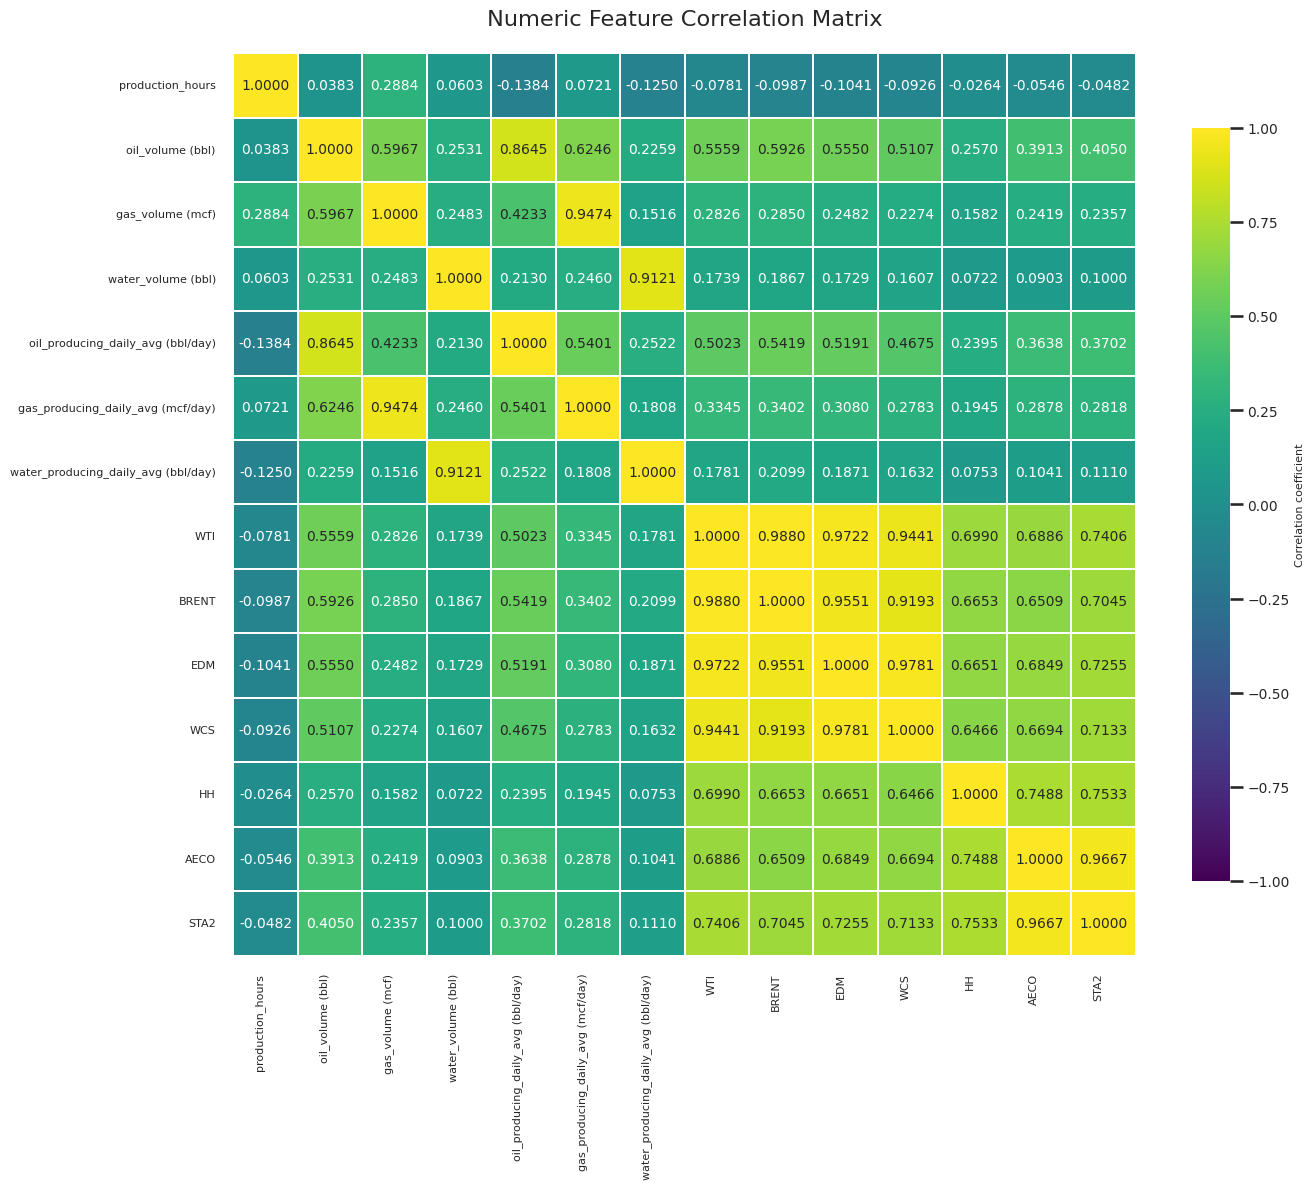

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix across all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

# Plot a viridis-themed heatmap that covers the full [-1, 1] correlation range
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.9)

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    corr_matrix,
    cmap='viridis',
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.4f',
    annot_kws={'size': 10},
    linewidths=0.3,
    cbar_kws={'label': 'Correlation coefficient', 'shrink': 0.8},
    square=True
)

# Downsize the colorbar (legend) text so it does not compete with the heatmap
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation coefficient', size=8)

# Shrink and rotate axis labels so the matrix itself fills most of the frame
heatmap.set_title('Numeric Feature Correlation Matrix', pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=8)
plt.tight_layout()

heatmap

> Correlations that were visually observed in the pairplot are confirmed in the correlation heatmap.

#### Production Time Series Plots
- Traditionally oil and natural gas production is plotted on a semi-log plot over time.
- These production plots typically include daily average oil, gas, and water production rates as well as the hours on production.

In [10]:
# Create friendly labels for the core production columns used in the plot
prod_rate_dict = {
    'production_hours':'Hours On Production (hrs)',
    'oil_producing_daily_avg (bbl/day)':'Oil Production (bbl/d)',
    'gas_producing_daily_avg (mcf/day)':'Gas Production (mcf/d)',
    'water_producing_daily_avg (bbl/day)':'Water Production (bbl/d)'
}

# Convert the production data into a tidy, long-form DataFrame for Altair
prod_rate_chart_df = (
    df[['well_name', 'date'] + [k for k in prod_rate_dict.keys()]]
        .rename(prod_rate_dict, axis=1)
        .replace({0:np.nan})
        .melt(id_vars=['well_name', 'date'], value_vars=[v for v in prod_rate_dict.values()])
)

# Plot log-scaled time series for oil, gas, water, and runtime across each well
alt.Chart(prod_rate_chart_df).mark_line().encode(
    alt.X('date:T').title(None),
    alt.Y('value:Q').scale(type='log').title('Production Rate (bb/d or mcf/d)'),
    alt.Color('variable:N').scale(domain=[v for v in prod_rate_dict.values()], range=['grey', '#2ca02c', '#d62728', 'steelblue']),
    alt.Row('well_name:N').title(None),
    alt.Tooltip(['value:Q'])
).properties(
    height = 200,
    width = 800,
    title=alt.Title('Oil, Gas, and Water Production Rates Over Time', fontSize=20, anchor='start')
).interactive()

alt.Chart(...)

> - Well #2, 4, and 5 have some odd natural gas production and hours on values at the end of their producing windows. I'm going to consider removing these outlier values during Data Cleaning.
> - There seem to be some dates that have missing values which is causing a sharp transition between dates. These missing dates will be handled during Data Cleaning so that only months where production exists are used for analysis.

#### Oil Production Rate Moving Averages
- Visualizing the 12 month, 24, and 36 months oil production rate moving averages.

In [11]:
# Prepare the oil production data for moving-average smoothing, ignoring zero placeholders
ma_chart_df = df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']].replace({0:np.nan})

# Define the moving-average windows and colors that will be layered together
window_specs = [
    (12, '12-month MA'),
    (24, '24-month MA'),
    (36, '36-month MA'),
]

window_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
color_scale = alt.Scale(
    domain=[label for _, label in window_specs],
    range=window_colors
)

# Build a reusable base chart shared by the raw line and each moving-average layer
base = alt.Chart(ma_chart_df).encode(
    alt.X('date:T').title('Date')
)

# Show the original series in light green for context
raw_line = base.mark_line(color='green', opacity=0.2, size=5).encode(
    alt.Y('oil_producing_daily_avg (bbl/day):Q').title('Oil producing daily avg (bbl/day)').scale(type='log')
)

# Create each moving-average line and collect it for layering
ma_layers = []
for window, label in window_specs:
    ma_layer = base.transform_window(
        rolling_mean='mean(oil_producing_daily_avg (bbl/day))',
        frame=[-(window - 1), 0],
        groupby=['well_name'],
        sort=[alt.SortField('date')]
    ).transform_calculate(
        window_label=f"'{label}'"
    ).mark_line(size=3, opacity=0.75, strokeDash=[10,4]).encode(
        y='rolling_mean:Q',
        color=alt.Color('window_label:N').scale(color_scale).title('Moving Average')
    ).properties(
        height = 200,
        width = 800,
    )
    ma_layers.append(ma_layer)

# Layer the raw series with every moving-average line and facet by well
layered_ma_chart = alt.layer(*ma_layers, raw_line).facet(
    row=alt.Row('well_name:N', title='Well')
).properties(
    title=alt.Title('12, 24, and 36 Month Moving Averages for the Oil Production Rate (bbl/d)', fontSize=20, anchor='start')
)

layered_ma_chart

alt.FacetChart(...)

> The 12-, 24-, and 36-month moving average curves show that every well’s oil production rate follows a steady downward slope, with the longer windows smoothing out the month-to-month volatility. Large negative spikes mark occasional shut-ins or outages, but the multi-year trend remains a gradual decline across all wells.

#### Oil Production Percent Change
- The month-to-month percent change chart tracks how each well’s production jumps or drops from one month to the next, helping the analysis identify volatility bursts or shut-in events to account for when modeling the LSTM

In [12]:
# Compute month-over-month percent change in oil production for each well
pct_change_df = df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']].copy()
pct_change_df = pct_change_df.sort_values(['well_name', 'date'])
pct_change_df['pct_change'] = pct_change_df.groupby('well_name')['oil_producing_daily_avg (bbl/day)'].pct_change() * 100
pct_change_df = pct_change_df.dropna(subset=['pct_change'])
pct_change_df['pct_change'] = pct_change_df['pct_change'].clip(-100, 100)

# Define the color palette that differentiates positive from negative swings
color_scale = alt.Scale(domain=['Increase', 'Decrease'], range=['#2ca02c', '#d62728'])

# Plot a faceted bar chart showing capped percent changes for every well
pct_change_chart = alt.Chart(pct_change_df).mark_bar().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('pct_change:Q', title='Month-to-month % change', scale=alt.Scale(domain=[-100, 100])),
    color=alt.Color(
        'change_direction:N',
        scale=color_scale,
        legend=alt.Legend(title='Direction')
    ),
    tooltip=[
        alt.Tooltip('well_name:N', title='Well'),
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('pct_change:Q', title='% change', format='.2f')
    ]
).transform_calculate(
    change_direction="datum.pct_change >= 0 ? 'Increase' : 'Decrease'"
).properties(
    height=200,
    width=800
).facet(
    row=alt.Row('well_name:N', title='Well')
).resolve_scale(
    y='shared'
).properties(
    title=alt.Title('Month-to-Month Percent Change of the Oil Production Rate', fontSize=20, anchor='start', subtitle='(capped at +/-100%)')
)

pct_change_chart

alt.FacetChart(...)

> - More negative rather than positive percent changes are prevalent for each well. This makes sense because the production rate typically consistently declines over time.
> - It would be interesting to understand what occurred to the well to cause an increase in oil production.

#### Seasonal Decomposition Plots
- Seasonal decomposition charts break each time series into trend, seasonal, and residual components, revealing long-term decline, recurring seasonal patterns, and irregular shocks separately.
- In this analysis they help determine whether seasonal patterns or residual noise should be modeled explicitly or if the LSTM can focus mostly on the trend and notable anomalies.

In [13]:
# Collect seasonal decomposition components for every well
decomposition_records = []
value_col = 'oil_producing_daily_avg (bbl/day)'

for well_name, group in df[['well_name', 'date', value_col]].dropna(subset=[value_col]).sort_values('date').groupby('well_name'):
    well_series = group.set_index('date')[value_col]
    monthly_series = well_series.resample('MS').mean().interpolate(limit_direction='both')

    if len(monthly_series.dropna()) < 24:
        continue

    decomposition = seasonal_decompose(
        monthly_series,
        model='additive',
        period=12,
        extrapolate_trend='freq'
    )

    component_map = {
        'Observed': decomposition.observed,
        'Trend': decomposition.trend,
        'Seasonal': decomposition.seasonal,
        'Residual': decomposition.resid
    }

    for component_name, component_values in component_map.items():
        component_df = component_values.reset_index()
        component_df.columns = ['date', 'value']
        component_df['component'] = component_name
        component_df['well_name'] = well_name
        decomposition_records.append(component_df)

# Combine component data and drop rows created by leading/trailing NaNs
seasonal_decomposition_df = pd.concat(decomposition_records, ignore_index=True)
seasonal_decomposition_df = seasonal_decomposition_df.dropna(subset=['value'])
component_order = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Plot the observed, trend, seasonal, and residual series for each well in a faceted grid
seasonal_decomposition_chart = alt.Chart(seasonal_decomposition_df).mark_line(color='#2ca02c').encode(
    x=alt.X('date:T').title(None),
    y=alt.Y('value:Q').title(None),
    row=alt.Row('component:N', sort=component_order, title=None),
    column=alt.Column('well_name:N', title='Well'),
).resolve_scale(
    y='independent'
).properties(
    height=100,
    width=200,
    title=alt.Title('Seasonal Decomposition of the Oil Production Rate', fontSize=20, anchor='start')
)

seasonal_decomposition_chart

alt.Chart(...)

> The seasonal decomposition charts show a steep decline in each well’s long-term trend followed by a flat tail, while the seasonal component oscillates annually with consistent amplitude—**clear evidence of recurring seasonality**. Residuals remain relatively small after the initial drop, suggesting most structure is captured by the trend and seasonal terms, and confirming that the LSTM should account for these cyclical effects to avoid mistaking them for noise.

#### Autocorrelation Plot
- The autocorrelation plot shows how each well’s production correlates with its past values at different lags, helping this analysis gauge how far back the LSTM needs to look to capture meaningful temporal dependencies.

In [14]:
from statsmodels.tsa.stattools import acf

# Define the horizons (in months) to evaluate and prep storage for the results
horizon = 36
value_col = 'oil_producing_daily_avg (bbl/day)'
acf_records = []

# Group by well so we can compute autocorrelation on each monthly time series
well_groups = (
    df[['well_name', 'date', value_col]]
    .dropna(subset=[value_col])
    .sort_values('date')
    .groupby('well_name')
)

for well_name, group in well_groups:
    monthly_series = (
        group.set_index('date')[value_col]
        .resample('MS')
        .mean()
        .interpolate(limit_direction='both')
    )

    if len(monthly_series.dropna()) <= horizon:
        continue

    acf_values = acf(monthly_series, nlags=horizon, fft=False, missing='drop')

    # for horizon in horizons:
    for lag in range(1, horizon + 1):
        acf_records.append({
            'well_name': well_name,
            'lag': lag,
            'acf': acf_values[lag],
            'horizon_label': f"{horizon}-month"
        })

# Convert the records into a DataFrame for Altair and build the bar chart
acf_df = pd.DataFrame(acf_records)
horizon_order = [f"36-month"]

acf_chart = alt.Chart(acf_df).mark_bar().encode(
    x=alt.X(
        'lag:O',
        title='Lag (months)',
        axis=alt.Axis(values=[6, 12, 18, 24, 30, 36])
    ),
    y=alt.Y('acf:Q', title='Autocorrelation', scale=alt.Scale(domain=[-1, 1])),
    column=alt.Column('well_name:N', title=None),
    row=alt.Row('horizon_label:N', sort=horizon_order, title='Horizon'),
    color=alt.condition(
        alt.datum.acf >= 0,
        alt.value('#1f77b4'),
        alt.value('#d62728')
    ),
    tooltip=[
        alt.Tooltip('well_name:N', title='Well'),
        alt.Tooltip('horizon_label:N', title='Horizon'),
        alt.Tooltip('lag:Q', title='Lag (months)'),
        alt.Tooltip('acf:Q', title='ACF', format='.2f')
    ]
).resolve_scale(
    y='shared'
).properties(
    height=200,
    width=200,
    title=alt.Title('36 month Autocorrelation of the Oil Production Rate', fontSize=20, anchor='start')
)

acf_chart

alt.Chart(...)

> Autocorrelation stays strongly positive through roughly the first 12–18 months for every well, confirming that recent production levels heavily influence the next year’s output. Beyond about two years the correlations decay to near zero or slightly negative, suggesting the model can safely prioritize shorter lookback windows without losing much signal.

## DATA CLEANING & PREPROCESSING

#### Drop Columns
- The production volume columns will be removed from the dataset because they contain redundant information and may cause overfitting during training if left in the dataset.

In [15]:
# Drop unnecessary columns
df = df.drop(['oil_volume (bbl)', 'gas_volume (mcf)', 'water_volume (bbl)'], axis=1)

#### Add Columns
- A `months_on` column is added that calculates the number of months the well has been on production since its first month of production.
- A set of dummy variables are created that define general states of the oil and gas industry over time and added to the dataset. These dummy variables are used to help model training.

In [16]:
# Add a months_on column which is the number of months a well has produced since it was first put on production
df['months_on'] = df.groupby('well_name')['date'].transform(lambda s: s.rank(method='first').astype(int))

In [17]:
# Build dummy indicators for WTI price dynamics using historically-informed windows
min_prod_date = df['date'].min().to_period('M').to_timestamp()
date_index = pd.date_range(start=min_prod_date, end='2025-11-01', freq='MS')

# Manually define periods that align with key macro / geopolitical events affecting WTI price
indicator_windows = {
    'middle_instability_tightening_supply': [('2009-01-01', '2014-08-01')],
    'opec_oversupply_during_downturn':      [('2014-09-01', '2016-02-01')],
    'opec_undersupply_during_recovery':     [('2016-03-01', '2020-02-01')],
    'covid':                                [('2020-03-01', '2022-06-01')],
    'ukraine_war':                          [('2022-02-01', '2025-11-01')]
}

wti_dummy_df = pd.DataFrame({'date': date_index})

for indicator, windows in indicator_windows.items():
    wti_dummy_df[indicator] = 0
    for start, end in windows:
        start_ts = pd.Timestamp(start)
        end_ts = pd.Timestamp(end)
        mask = (wti_dummy_df['date'] >= start_ts) & (wti_dummy_df['date'] <= end_ts)
        wti_dummy_df.loc[mask, indicator] = 1

# Merge wti_dummy_df with the dataset
df = df.merge(wti_dummy_df)

# Display the updated dataset
df

,well_name,date,production_hours,oil_producing_daily_avg (bbl/day),gas_producing_daily_avg (mcf/day),water_producing_daily_avg (bbl/day),WTI,BRENT,EDM,WCS,HH,AECO,STA2,months_on,middle_instability_tightening_supply,opec_oversupply_during_downturn,opec_undersupply_during_recovery,covid,ukraine_war
0,well_1,2013-01-01,408,16453.411765,5068.647059,1439.235294,94.83,112.16,88.10,62.09,3.33,3.18,3.08,1,1,0,0,0,0
1,well_1,2013-02-01,629,16161.119237,5106.848967,388.769475,95.32,116.02,87.12,58.36,3.33,3.03,2.84,2,1,0,0,0,0
2,well_1,2013-03-01,743,15883.833109,9696.032301,335.224764,92.96,108.56,86.95,66.71,3.81,2.96,2.79,3,1,0,0,0,0
3,well_1,2013-04-01,720,12569.133333,10888.633333,119.500000,92.07,102.25,89.04,68.79,4.17,3.39,3.18,4,1,0,0,0,0
4,well_1,2013-05-01,696,10410.724138,7586.517241,169.172414,94.80,102.56,93.55,81.07,4.04,3.63,3.42,5,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,well_5,2018-08-01,120,100.600000,70.600000,25.200000,68.06,72.53,64.93,48.91,2.91,1.58,1.08,68,0,0,1,0,0
478,well_5,2018-09-01,720,54.500000,188.333333,264.166667,70.23,78.89,61.94,40.84,2.90,1.05,1.04,69,0,0,1,0,0
479,well_5,2019-03-01,27,0.000000,941.333333,0.000000,58.15,66.14,54.49,48.06,2.95,1.55,0.99,70,0,0,1,0,0
480,well_5,2019-04-01,24,0.000000,1413.000000,0.000000,63.86,71.23,59.16,53.26,2.65,1.16,0.65,71,0,0,1,0,0


#### Create Individual Well Datasets
- Each well will be trained separately so wells are first broken out into their own respective datasets.
- Rows of data are added where missing dates occur to ensure a consistent set of dates throughout the datasets. A `well_shut_in` column is added to indicate if a well is on or off production.
- Outlier dates identified during EDA will be removed for wells # 2, 4, and 5.

In [18]:
# Establish the shared date bounds and include a well_shut_in flag before creating per-well datasets
global_min_date = df['date'].min()
global_max_date = df['date'].max()
well_names = sorted(df['well_name'].unique())

# Well-specific shut-in dates
well_end_dates = {
    'well_1': pd.Timestamp('2020-12-01'),
    'well_2': pd.Timestamp('2021-05-01'),
    'well_3': pd.Timestamp('2019-09-01'),
    'well_4': pd.Timestamp('2022-01-01'),
    'well_5': pd.Timestamp('2018-09-01'),
}

filled_well_dfs = {}

for well_name in well_names:
    well_df = df[df['well_name'] == well_name].sort_values('date')

    end_date = well_end_dates.get(well_name, global_max_date)
    well_df = well_df[well_df['date'] <= end_date]

    first_prod_date = well_df['date'].min()
    # if pd.isna(first_prod_date):
    #     continue

    start_date = max(global_min_date, first_prod_date)

    # if start_date > end_date:
    #     continue

    monthly_index = pd.date_range(start=start_date, end=end_date, freq='MS')

    reindexed = well_df.set_index('date').reindex(monthly_index)
    missing_mask = reindexed['well_name'].isna()

    reindexed['well_name'] = well_name
    reindexed['well_shut_in'] = np.where(missing_mask, 1, 0)

    reindexed = reindexed.reset_index().rename(columns={'index': 'date'})
    filled_well_dfs[well_name] = reindexed

# Combine all wells so any downstream analysis has aligned monthly coverage
shut_in_augmented_df = (
    pd.concat(filled_well_dfs.values(), ignore_index=True)
      .sort_values(['well_name', 'date'])
)

# Create convenience DataFrames for each individual well from the gap-filled data
augmented_well_dfs = {
    well_name: filled_well_dfs.get(well_name, pd.DataFrame())
    for well_name in ['well_1', 'well_2', 'well_3', 'well_4', 'well_5']
}

# Split wells into individual datasets for training and analysis
well_1_df = augmented_well_dfs['well_1']
well_2_df = augmented_well_dfs['well_2']
well_3_df = augmented_well_dfs['well_3']
well_4_df = augmented_well_dfs['well_4']
well_5_df = augmented_well_dfs['well_5']

#### Train-Test Split Function
- LSTM expect a 3D dataframe as input with a shape of ($\textit{samples}$, $\textit{look back}$, $\textit{number of features}$)
  - Where:
    - $\textit{samples}$ = are the number of unique time slices generated from $X$
    - $\textit{look back}$ = is the length of each sample (measured in months)
    - $\textit{number of features}$ = are the number of feature variables in the input matrix $X$
- The function below splits an input dataset into a feature dataset $X$ and target dataset $y$
  - The target values $y$ are the `oil_producing_daily_avg (bbl/day)` values taken at time $t+1$
  - The feature matrix $X$ contains 18 features:
    - `oil_producing_daily_avg (bbl/day)`
    - `gas_producing_daily_avg (mcf/day)`
    - `water_producing_daily_avg (bbl/day)`
    - `WTI`
    - `BRENT`
    - `EDM`
    - `WCS`
    - `HH`
    - `AECO`
    - `STA2`
    - `months_on`
    - `middle_instability_tightening_supply`
    - `opec_oversupply_during_downturn`
    - `opec_undersupply_during_recovery`
    - `covid`
    - `ukraine_war`
- $X$ and $y$ are split into training and testing sets, where:
  - the first 80% of the time series is used as the training set, and 
  - the last 20% of the time series is used as the testing set
- Scaling is applied where:
  - $X$ is scaled using a standard scaler (to a mean = 0 and standard deviation = 1)
  - $y$ is log transformed (with a scaling factor of 1e-6 added to avoid errors when $y=0$)

In [19]:
# Function to scale and split a dataset into X_train, X_test, y_train, y_test
def create_dataset(dataset, look_back):
    # Drop date, well_name, well_shut_in columns
    dataset = dataset[[col for col in dataset.columns if col not in ['date', 'well_name', 'well_shut_in']]]

    # Drop any rows that are NA in the 'oil_producing_daily_avg (bbl/day)' column
    dataset = dataset.dropna(subset='oil_producing_daily_avg (bbl/day)').reset_index(drop=True)

    # Split into X & y
    X = dataset.iloc[0:(len(dataset)-1), :]
    y = dataset.iloc[1:, 1]

    # Scale the features X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Log transform y
    y_log = np.log(y + SCALING_FACTOR).to_numpy()

    # Split into train & test sets
    train_idx = int(len(X_scaled) * SPLIT_RATIO)
    X_train, X_test, y_train, y_test = [], [], [], []

    # Create X_train & y_train datasets
    for i in range(train_idx - look_back + 1):
        X_train_sample = X_scaled[i:(i + look_back), :]
        X_train.append(X_train_sample)
        y_train.append(y_log[i + look_back - 1])
    X_train = np.array(X_train) # X_train.shape = (train_idx - look_back + 1, look_back, n_features)
    y_train = np.array(y_train) # y_train.shape = (train_idx - look_back + 1, )

    # Create X_test & y_test datasets
    for i in range(train_idx - look_back + 1, len(X) - look_back + 1):
        X_test_sample = X_scaled[i:(i+look_back), :]
        X_test.append(X_test_sample)
        y_test.append(y_log[i + look_back - 1])
    X_test = np.array(X_test) # X_test.shape = (len(X) - train_idx, look_back, n_features)
    y_test = np.array(y_test) # y_test.shape = (len(y) - train_idx, )

    return X_train, X_test, y_train, y_test

In [20]:
# Train-test split example (for well_1)
well_name = 'well_1'
dataset = augmented_well_dfs[well_name]
look_back = 1    # create samples of length = 12 months

X_train, X_test, y_train, y_test = create_dataset(dataset, look_back)

print(f'''
{well_name} dataset shapes:
-> X_train and X_test have shape = (samples, look_back, n_features):
    X_train = {X_train.shape}
    X_test  = {X_test.shape}
-> y_train and y_test have shape = (samples, )
    y_train = {y_train.shape}
    y_test  = {y_test.shape}
''')


well_1 dataset shapes:
-> X_train and X_test have shape = (samples, look_back, n_features):
    X_train = (70, 1, 17)
    X_test  = (18, 1, 17)
-> y_train and y_test have shape = (samples, )
    y_train = (70,)
    y_test  = (18,)



## DECLINE ANALYSIS MODELING
- Description & importance
  - how its always been done in industry

#### Exponential Decline Formula
- ...

#### Decline Charts
- ...

#### Decline Rates
- ...

## LSTM MODELING
....

#### Create LSTM Model
- ...
- Function to fit an LSTM model and generate
  - Train test RMSE
  - Loss plot (20% val)
  - Test and train actual vs pred line plot

In [ ]:
# Function to create base LSTM model
def create_base_lstm_model(well_name, n_nodes, look_back, n_features, specs=False):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(look_back, n_features)))
    model.add(Dense(1, activation='softplus'))
    model.compile(loss='mse', optimizer='adam')
    if specs:
        print('============================================================================')
        print(f'Model Specifications ({well_name})')
        print('============================================================================')
        model.summary()
    return model

# Function to plot train vs validation loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Train Loss vs Validation Loss ({well_name})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

def plot_actual_vs_predicted(history, y_train, y_test, trainPredict, testPredict):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), sharey=True)
    ax1.plot(y_train, label='y_train Actual')
    ax1.plot(trainPredict, label='y_train Predicted')
    ax1.legend()
    ax1.set_ylabel('Oil Production Rate (bbl/d)')
    ax1.set_xlabel('Months')

    ax2.plot(y_test, label='y_test Actual')
    ax2.plot(testPredict, label='y_test Predicted')
    ax2.legend()
    ax2.set_xlabel('Months')

    fig.suptitle(f'Oil Production Rate Train/Test Actual vs Predicted ({well_name})')

# Fit base LSTM and create diagnostic plots
def fit_lstm(well_name, look_back, n_nodes, epochs):
    # Create dataset
    dataset = augmented_well_dfs[well_name]
    X_train, X_test, y_train, y_test = create_dataset(dataset, look_back)

    # Create model instance
    n_features = X_train.shape[2]
    specs = False
    model = create_base_lstm_model(well_name, n_nodes, look_back, n_features, specs=specs)
    
    # Fit model
    if specs:
        print('\n============================================================================')
        print(f'Model Training ({well_name})')
        print('============================================================================\n')
        vb = 1
    else:
        vb = 0
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_split=(1-SPLIT_RATIO), shuffle=False, verbose=vb)

    # Make predictions
    trainPredict = model.predict(X_train, verbose=0)
    testPredict = model.predict(X_test, verbose=0)

    # Unscale target variables and predictions
    y_train = np.exp(y_train) - SCALING_FACTOR
    trainPredict = np.exp(trainPredict) - SCALING_FACTOR
    y_test = np.exp(y_test) - SCALING_FACTOR
    testPredict = np.exp(testPredict) - SCALING_FACTOR

    # Calculate RMSE
    print('\n============================================================================')
    print(f'Root Mean Squared Error Scores ({well_name})')
    print('============================================================================\n')   
    train_rmse = np.sqrt(mean_squared_error(y_train, trainPredict))
    test_rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    print(f'Train RMSE: {train_rmse:,.1f}')
    print(f'Test RMSE: {test_rmse:,.1f}\n')

    # Create diagnostic plots
    print('\n============================================================================')
    print(f'Diagnostic Plots ({well_name})')
    print('============================================================================\n')   
    plot_loss(history)
    plot_actual_vs_predicted(history, y_train, y_test, trainPredict, testPredict)

#### Well 1 Base LSTM Prediction

In [ ]:
# Define base LSTM model inputs
look_back = 3
n_nodes = 5
epochs = 10

# Fit LSTM model for well_1
# fit_lstm('well_1', look_back, n_nodes, epochs)

In [ ]:
# Fit LSTM model for well_2 (using same model inputs as well_1)
# fit_lstm('well_2', look_back, n_nodes, epochs)

In [ ]:
# Fit LSTM model for well_3 (using same model inputs as well_1)
# fit_lstm('well_3', look_back, n_nodes, epochs)

In [ ]:
# Fit LSTM model for well_4 (using same model inputs as well_1)
# fit_lstm('well_4', look_back, n_nodes, epochs)

In [ ]:
# Fit LSTM model for well_5 (using same model inputs as well_1)
# fit_lstm('well_5', look_back, n_nodes, epochs)

## HYPERPARAMETER TUNING

HPs
- Look-back window
- nodes/layers
- epochs

In [ ]:
# Cache datasets so each well/look_back pair is only prepared once
def create_cached_datasets(well_name_grid, look_back_grid):
    cached_datasets = {}
    for well_name in well_name_grid:
        df = augmented_well_dfs[well_name]
        for look_back in look_back_grid:
            X_train, X_test, y_train, y_test = create_dataset(df, look_back)
            cached_datasets[(well_name, look_back)] = (
                X_train,
                X_test,
                y_train,
                y_test,
                X_train.shape[2],
            )
    return cached_datasets

# Function to run a single tuning trial
def evaluate_trial(params, cached_datasets):
    # Define hyperparameters to tune
    well_name, look_back, n_nodes, epochs = params

    # Extract cached dataset
    X_train, X_test, y_train, y_test, n_features = cached_datasets[(well_name, look_back)]

    # Create & fit LSTM model
    model = create_base_lstm_model(well_name, n_nodes, look_back, n_features)
    model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_split=SPLIT_RATIO, shuffle=False, verbose=0)

    # Make predictions
    testPredict = model.predict(X_test, verbose=0)

    # Unscale target variables and predictions
    y_test = np.exp(y_test) - SCALING_FACTOR
    testPredict = np.exp(testPredict) - SCALING_FACTOR
    
    # Calculate RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, testPredict))

    # Clear session
    keras.utils.clear_session(free_memory=True)

    print(f'{well_name} - look_back={look_back}  n_nodes={n_nodes}  epochs={epochs}  rmse={test_rmse}')

    return {
        'well_name': well_name,
        'look_back': look_back,
        'n_nodes': n_nodes,
        'epochs': epochs,
        'test_rmse': float(test_rmse),
    }

# Define parameter grid
# well_name_grid = ['well_1', 'well_2', 'well_3', 'well_4', 'well_5']
# look_back_grid = [1, 3, 6, 9, 12]
# num_nodes_grid = [10, 20, 30, 40, 50]
# epochs_grid = [100, 500, 1000, 1500, 2000]

well_name_grid = ['well_1', 'well_2', 'well_3', 'well_4', 'well_5']
look_back_grid = [1,2,3,4,5]
n_nodes_grid = [1,2,3,4,5]
epochs_grid = [1,2,3,4,5]
search_space = list(itertools.product(well_name_grid, look_back_grid, n_nodes_grid, epochs_grid))

# Create cached datasets
cached_datasets = create_cached_datasets(well_name_grid, look_back_grid)

# Create tuning datafame summary
rmse_results = [evaluate_trial(params, cached_datasets) for params in search_space]
rmse_df = pd.DataFrame(rmse_results).sort_values('test_rmse').reset_index(drop=True)
rmse_df.to_csv('tuning_rmse_results.csv', index=False)
rmse_df

In [ ]:
well_name_grid = ['well_1', 'well_2', 'well_3', 'well_4', 'well_5']
look_back_grid = [1,3,6,9,12]
n_nodes_grid = [i*10 for i in range(1,6)]
epochs_grid = [i*1000 for i in range(1,6)]
somelists = [well_name_grid, look_back_grid, n_nodes_grid, epochs_grid]

import pandas as pd
import itertools
random.random()
rmse_df = pd.DataFrame([x for x in itertools.product(*somelists)], columns=['well_name', 'look_back', 'n_nodes', 'epochs'])
rmse_df['rmse'] = [random.random() for x in range(len(rmse_df))]
rmse_df

,well_name,look_back,n_nodes,optimizers,epochs,rmse
0,well_1,1,10,adagrad,1000,0.500627
1,well_1,1,10,adagrad,2000,0.811359
2,well_1,1,10,adagrad,3000,0.553674
3,well_1,1,10,adagrad,4000,0.712175
4,well_1,1,10,adagrad,5000,0.123142
...,...,...,...,...,...,...
1870,well_5,12,50,adam,1000,0.711690
1871,well_5,12,50,adam,2000,0.037471
1872,well_5,12,50,adam,3000,0.484618
1873,well_5,12,50,adam,4000,0.444970


#### Exponential Smoothing Time Series (ETS)
- ...

#### Prophet
- ...

## RESULTS & ANALYSIS
...

## CONCLUSION
- Basic reiteration of results
- Discussion of learning and takeaways
- Discussion of why something didn’t work.
- Suggestions for ways to improve. 